# Exercise 4: Neural Networks Learning

Hand-written digits recognition with neural networks, focussing on the backpropagation algorithm for gradient computation and learning. The digits are a subset of the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) by Yann LeCun.

Files provided by Coursera, located under `../exercises/ex1-ex8-octave/ex4`

- `ex4.m` - Octave/MATLAB script that steps you through the exercise
- `ex4data1.mat` - Training set of hand-written digits
- `ex4weights.mat` - Initial weights for the neural network
- `submit.m` - Submission script that sends your solutions to our servers
- `displayData.m` - Function to help visualize the dataset
- `fmincg.m` - Function minimization routine (similar to `fminunc`)
- `sigmoid.m` - Sigmoid function
- `computeNumericalGradient.m` - Numerically compute gradients
- `checkNNGradients.m` - Function to help check your gradients
- `debugInitializeWeights.m` - Function for initializing weights
- `predict.m` - Neural network prediction function


Files to complete:

- `sigmoidGradient.m` - Compute the gradient of the sigmoid function
- `randInitializeWeights.m` - Randomly initialize weights
- `nnCostFunction.m` - Neural network cost function
- `predict.m` - Neural network prediction function

Workflow:

- Download latest Octave version of exercise from Coursera
- Complete code in exercise files following `ex4.pdf`
- Whenever an exercise part is finished
  - Check it with `ex4` in Octave terminal
  - Create a submission token on Coursera (exercise submission page, it lasts 30 minutes)
  - Execute `submit` in Octave terminal
  - Introduce email and token
  - Results appear

**Overview of contents:**

0. Setup: `gnuplot`
1. A



## 0. Setup: `gnuplot`

In [89]:
graphics_toolkit ("gnuplot");

In [90]:
%plot -b inline:gnuplot

## 1. Dataset Loading & Visualization

In [91]:
% Load saved matrices from file
load('ex4data1.mat');
% The matrices X and y will now be in your Octave environment

In [92]:
who

Variables visible from the current scope:

J                  ans                lambda             rand_indices
Theta1             e                  m                  sel
Theta1_grad        grad               matches            t1
Theta2             h                  nn_params          t2
Theta2_grad        hidden_layer_size  num                y
X                  input_layer_size   num_labels         yh
a                  k                  p



In [93]:
% X: 5000 examples of unrolled 20x20 pixel images containing hand-written digits
% pixels contain grayscale intensities
size(X)

ans =

   5000    400



In [94]:
% y: true label for each example: 1-9, 10:0 (label 10 means digit 0)
size(y)

ans =

   5000      1



In [95]:
% Check min and max values
disp([max(X(1,:)),min(X(1,:))])
disp([max(y(:)),min(y(:))])

   1.047483  -0.057515
   10    1


In [96]:
% Randomly select 100 data points to display
m = size(X, 1);
rand_indices = randperm(m);
num = 10; % num^2 images are visualized in a tiled canvas
sel = X(rand_indices(1:num^2), :);

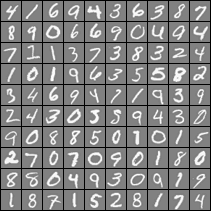

In [97]:
% Function provided in the course
% See how sel is created
% Otherwise, the numer of tiles in the image width can be passed as param (see function)
displayData(sel);

## 2. Model

In [98]:
% Load saved matrices from file
load('ex4weights.mat');
% The matrices Theta1 and Theta2 will now be in your workspace
% Theta1 has size 25 x 401
% Theta2 has size 10 x 26

In [99]:
who

Variables visible from the current scope:

J                  ans                lambda             rand_indices
Theta1             e                  m                  sel
Theta1_grad        grad               matches            t1
Theta2             h                  nn_params          t2
Theta2_grad        hidden_layer_size  num                y
X                  input_layer_size   num_labels         yh
a                  k                  p



In [100]:
% input = 400 + 1 (bias)
% out = 25
size(Theta1)

ans =

    25   401



In [101]:
% in = 25 + 1 (bias)
% output = 10 (classes)
size(Theta2)

ans =

   10   26



![Neural network model](./neural_network.png)

## 3. Feedforward and Cost Function: `nnCostFunction.m`

### 3.1 Feedforward

In [102]:
function p = infer(Theta1, Theta2, X)
    % Sizes
    m = size(X, 1);
    num_labels = size(Theta2, 1);
    % Initialize return variable: predictions
    p = zeros(size(X, 1), 1);
    % Layer 1
    a1 = [ones(size(X,1),1), X]; % 5000 x 401
    % Layer 1 -> Layer 2
    z2 = a1*Theta1'; % (5000 x 401) x (401 x 25) -> (5000 x 25)
    a2 = sigmoid(z2);
    a2 = [ones(size(a2,1),1), a2]; % bias -> (5000 x 26)
    % Layer 2 -> Layer 3
    z3 = a2*Theta2'; % (5000 x 26) x (26 x 10) -> (5000 x 10)
    a3 = sigmoid(z3);
    % Select class
    [v, p] = max(a3,[],2); % maximum column-value (v) and column-index (p) for each row
end

In [103]:
p = infer(Theta1, Theta2, X);

In [104]:
% Accuracy
matches = y == p;
sum(matches)/length(matches)

ans = 0.9752


### 3.2 Cost Function

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right]$$

$$y = [y_1, ..., y_k, ..., y_K]^T, \,\, y_k \in \{0,1\}$$

$$h = [h_1, ..., h_k, ..., h_K]^T, \,\, h_k \in [0,1]$$

$$h_k = a^{(L)}_k$$

In [105]:
function g = sigmoid(z)
    g = 1.0 ./ (1.0 + exp(-z));
end

In [106]:
function h = feedForward(Theta1, Theta2, X)
    % Sizes
    m = size(X, 1);
    num_labels = size(Theta2, 1);
    % Initialize return variable: predictions
    h = zeros(size(X, 1), 1);
    % Layer 1
    a1 = [ones(size(X,1),1), X]; % 5000 x 401
    % Layer 1 -> Layer 2
    z2 = a1*Theta1'; % (5000 x 401) x (401 x 25) -> (5000 x 25)
    a2 = sigmoid(z2);
    a2 = [ones(size(a2,1),1), a2]; % bias -> (5000 x 26)
    % Layer 2 -> Layer 3
    z3 = a2*Theta2'; % (5000 x 26) x (26 x 10) -> (5000 x 10)
    h = sigmoid(z3);
end

In [107]:
function [J, grad] = costFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda)
    % Theta vector: nn_params
    % Parameters are introduced unrolled, so we need to reshape the vector
    % using input_layer_size, hidden_layer_size, num_labels
    
    % 25 x 401: hidden_layer_size x (input_layer_size + 1)
    Theta1 = reshape(nn_params(1:hidden_layer_size * (input_layer_size + 1)), hidden_layer_size, (input_layer_size + 1));
    % 10 x 26: num_labels x (hidden_layer_size + 1)
    Theta2 = reshape(nn_params((1 + (hidden_layer_size * (input_layer_size + 1))):end), num_labels, (hidden_layer_size + 1));
                 
    % Number of examples
    m = size(X,1);
    
    % Initialize return variables
    J = 0;
    Theta1_grad = zeros(size(Theta1));
    Theta2_grad = zeros(size(Theta2));
    grad = [Theta1_grad(:) ; Theta2_grad(:)];
    
    %%% Feedforward
    % h: 5000 x 10
    h = feedForward(Theta1, Theta2, X);
    
    %%% Part 1: Cost
    
    % Re-arrange y: one-hot encoding
    yh = zeros(size(y, 1), num_labels); % 5000 x 10
    for k = 1:num_labels
        yh(:,k) = y == k;
    end
    
    % Error: for each class, then sum
    e = zeros(1, num_labels);
    for k = 1:num_labels
        e(k) = -yh(:,k)'*log(h(:,k)) - (1 .- yh(:,k))'*log(1 .- h(:,k));
    end
    E = sum(e);
    J = (1.0/m)*E;
    
    %%% Part 2: Regularization of the Cost Function
    % TBD

    %%% Part 3: Backpropagation & Gradient Computation
    % TBD
    
    %%% Part 4: Regularization Component of the Gradient
    % TBD
    
    % Unroll gradients
    grad = [Theta1_grad(:) ; Theta2_grad(:)];

end

In [108]:
nn_params = [Theta1(:) ; Theta2(:)];
input_layer_size  = 400;  % 20x20 Input Images of Digits
hidden_layer_size = 25;   % 25 hidden units
num_labels = 10;          % 10 labels, from 1 to 10 
lambda = 3;
[J, grad] = costFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda);
disp(J);

0.2876


### 3.3 Regularized Cost Function

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right] + \frac{\lambda}{2 m} \left[ \sum_{j=1}^{25} \sum_{k=1}^{400} \left( \Theta_{j,k}^{(1)} \right)^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} \left( \Theta_{j,k}^{(2)} \right)^2 \right] $$

Same function `costFunction` as before, but extended with regularization.

In [109]:
function [J, grad] = costFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda)
    % Theta vector: nn_params
    % Parameters are introduced unrolled, so we need to reshape the vector
    % using input_layer_size, hidden_layer_size, num_labels
    
    % 25 x 401: hidden_layer_size x (input_layer_size + 1)
    Theta1 = reshape(nn_params(1:hidden_layer_size * (input_layer_size + 1)), hidden_layer_size, (input_layer_size + 1));
    % 10 x 26: num_labels x (hidden_layer_size + 1)
    Theta2 = reshape(nn_params((1 + (hidden_layer_size * (input_layer_size + 1))):end), num_labels, (hidden_layer_size + 1));
                 
    % Number of examples
    m = size(X,1);
    
    % Initialize return variables
    J = 0;
    Theta1_grad = zeros(size(Theta1));
    Theta2_grad = zeros(size(Theta2));
    grad = [Theta1_grad(:) ; Theta2_grad(:)];
    
    %%% Feedforward
    % h: 5000 x 10
    h = zeros(size(X, 1), 1);
    % Layer 1
    a1 = [ones(size(X,1),1), X]; % 5000 x 401
    % Layer 1 -> Layer 2
    z2 = a1*Theta1'; % (5000 x 401) x (401 x 25) -> (5000 x 25)
    a2 = sigmoid(z2);
    a2 = [ones(size(a2,1),1), a2]; % bias -> (5000 x 26)
    % Layer 2 -> Layer 3
    z3 = a2*Theta2'; % (5000 x 26) x (26 x 10) -> (5000 x 10)
    h = sigmoid(z3);
    
    %%% Part 1: Cost
    
    % Re-arrange y: one-hot encoding
    yh = zeros(size(y, 1), num_labels); % 5000 x 10
    for k = 1:num_labels
        yh(:,k) = y == k;
    end
    
    % Error: for each class, then sum
    e = zeros(1, num_labels);
    for k = 1:num_labels
        e(k) = -yh(:,k)'*log(h(:,k)) - (1 .- yh(:,k))'*log(1 .- h(:,k));
    end
    E = sum(e);
    J = (1.0/m)*E;
    
    %%% Part 2: Regularization of the Cost Function
    t1 = Theta1(:,2:end)(:); % remove bias weight and unroll to column vector
    t2 = Theta2(:,2:end)(:); % remove bias weight and unroll to column vector
    R = (0.5*lambda/m) * (t1'*t1 + t2'*t2);
    J = J + R;
    
    %%% Part 3: Backpropagation & Gradient Computation
    % TBD

    %%% Part 4: Regularization Component of the Gradient
    % TBD
    
    % Unroll gradients
    grad = [Theta1_grad(:) ; Theta2_grad(:)];

end

In [110]:
nn_params = [Theta1(:) ; Theta2(:)];
input_layer_size  = 400;  % 20x20 Input Images of Digits
hidden_layer_size = 25;   % 25 hidden units
num_labels = 10;          % 10 labels, from 1 to 10 
lambda = 3;
[J, grad] = costFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda);
disp(J);

0.5761


## 4. Backpropagation: `nnCostFunction.m`

In this part, the same file `nnCostFunction.m` from the exercise folder needs to be edited/extended.
Similarly, the same notebook function `costFunction` will be extended.

### 4.1 Sigmoid Gradient: `sigmoidGradient.m`

$$ g'(z) = \frac{d}{dz} g(z) = g(z)\left(1-g(z)\right) $$

$$ \text{sigmoid}(z) = g(z) = \frac{1}{1 + e^{-z}} $$

In [111]:
function g = sigmoidGrad(z)
    g = zeros(size(z));
    g = sigmoid(z).*(1 .- sigmoid(z));
end

### 4.2 Random Initialization: `randInitializeWeights.m`

**Xavier Glorot Initialization** for symmetry breaking for each layer $l$ or weight matrix $\theta^{(l)}$ should be a uniform distrbution with the following radius $\epsilon$, function of the number of units $s$ in adjacent layers to $\theta^{(l)}$:

$$ \epsilon_{init} = \frac{\sqrt{6}}{\sqrt{s_l + s_{l+1}}} $$

$$ [-\epsilon_{init}, \epsilon_{init}] $$

In [112]:
% However, the epsilon value is fixed to 0.12 in the exercises
function W = randInitializeWeights(L_in, L_out)
    epsilon_init = 0.12;
    W = rand(L_out, 1 + L_in)*2*epsilon_init;
    W = W - epsilon_init;
end

### 4.3 Backpropagation

![Backpropagation](./ex4-backpropagation.png)

$$\delta_k^{(3)} = \left(a_k^{(3)} - y_k \right)$$

$$ \delta^{(2)} = \left( \Theta^{(2)} \right)^T \delta^{(3)} * g'\left(z^{(2)} \right)$$

$$ \Delta^{(l)} = \Delta^{(l)} + \delta^{(l+1)} (a^{(l)})^{(T)} $$

$$ \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)}$$

Notes:
- $\delta^{(l)}$ bias component needs to be removed, if there is any.
- $\Delta^{(l)}$ has the same size as $\Theta^{(l)}$, including bias weights.
- $a$, $z$, $\delta$, $\Delta$ are computed in a `for`-loop iterating each example: for each example one forward pass first, then error backpropagation, gradient accumulation; after looping all examples the accumulated gradient is normalized ($M$) and the regularization component can be added.


Same function `costFunction` as before, but extended to contain backpropagation.

In [113]:
function [J, grad] = costFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda)
    % Theta vector: nn_params
    % Parameters are introduced unrolled, so we need to reshape the vector
    % using input_layer_size, hidden_layer_size, num_labels
    
    % 25 x 401: hidden_layer_size x (input_layer_size + 1)
    Theta1 = reshape(nn_params(1:hidden_layer_size * (input_layer_size + 1)), hidden_layer_size, (input_layer_size + 1));
    % 10 x 26: num_labels x (hidden_layer_size + 1)
    Theta2 = reshape(nn_params((1 + (hidden_layer_size * (input_layer_size + 1))):end), num_labels, (hidden_layer_size + 1));
                 
    % Number of examples
    m = size(X,1);
    
    % Initialize return variables
    J = 0;
    Theta1_grad = zeros(size(Theta1));
    Theta2_grad = zeros(size(Theta2));
    grad = [Theta1_grad(:) ; Theta2_grad(:)];
    
    %%% Feedforward
    % h: 5000 x 10
    h = zeros(size(X, 1), 1);
    % Layer 1
    a1 = [ones(size(X,1),1), X]; % 5000 x 401
    % Layer 1 -> Layer 2
    z2 = a1*Theta1'; % (5000 x 401) x (401 x 25) -> (5000 x 25)
    a2 = sigmoid(z2);
    a2 = [ones(size(a2,1),1), a2]; % bias -> (5000 x 26)
    % Layer 2 -> Layer 3
    z3 = a2*Theta2'; % (5000 x 26) x (26 x 10) -> (5000 x 10)
    h = sigmoid(z3);
    
    %%% Part 1: Cost
    
    % Re-arrange y: one-hot encoding
    yh = zeros(size(y, 1), num_labels); % 5000 x 10
    for k = 1:num_labels
        yh(:,k) = y == k;
    end
    
    % Error: for each class, then sum
    e = zeros(1, num_labels);
    for k = 1:num_labels
        e(k) = -yh(:,k)'*log(h(:,k)) - (1 .- yh(:,k))'*log(1 .- h(:,k));
    end
    E = sum(e);
    J = (1.0/m)*E;
    
    %%% Part 2: Regularization of the Cost Function
    t1 = Theta1(:,2:end)(:); % remove bias weight and unroll to column vector
    t2 = Theta2(:,2:end)(:); % remove bias weight and unroll to column vector
    R = (0.5*lambda/m) * (t1'*t1 + t2'*t2);
    J = J + R;
    
    %%% Part 3: Backpropagation & Gradient Computation
    % We need to perform backpropagation in a for loop iterating examples
    % Note that I use transposed vectors:
    % in the script, column vectors are used,
    % but I take example rows from the X matrix,
    % and operate with them without converting them in column vectors
    D1 = zeros(size(Theta1));
    D2 = zeros(size(Theta2));
    for i = 1:m
        % Feedfoward
        a1 = [1, X(i,:)]; % 1 x 401
        z2 = a1*Theta1'; % (1 x 401) x (401 x 25) -> (1 x 25)
        a2 = sigmoid(z2);
        a2 = [ones(size(a2,1),1), a2]; % bias -> (1 x 26)
        z3 = a2*Theta2'; % (1 x 26) x (26 x 10) -> (1 x 10)
        h = sigmoid(z3); % 1 x 10
        % Error backpropagation
        d3 = h - yh(i,:); % 1 x 10
        d2 = Theta2' * d3' .* [1, sigmoidGrad(z2)]'; % (26 x 10) x (10 x 1) .x (26, 1)-> 
        % d1: there is no such thing, because we have the inputs in layer 1
        d2 = d2(2:end)'; % remove the bias component, transpose: 1 x 25
        % Gradient computation: Accumulate gradients
        D1 = D1 + d2'*a1; % (25 x 1) x (1 x 401) -> (25 x 401)
        D2 = D2 + d3'*a2; % (10 x 1) x (1 x 26) -> (10 x 26) 
    end
    % Normalize
    Theta1_grad = (1 / m) * D1;
    Theta2_grad = (1 / m) * D2;
    
    %%% Part 4: Regularization Component of the Gradient
    % TBD

    % Unroll gradients
    grad = [Theta1_grad(:) ; Theta2_grad(:)];

end

In [114]:
nn_params = [Theta1(:) ; Theta2(:)];
input_layer_size  = 400;  % 20x20 Input Images of Digits
hidden_layer_size = 25;   % 25 hidden units
num_labels = 10;          % 10 labels, from 1 to 10 
lambda = 3;
[J, grad] = costFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda);
disp(J);

0.5761


### 4.4 Gradient Checking: `computeNumericalGradient.m`

$$ f_i\left( \theta \right) \approx \frac{J\left( \theta^{(i+)}\right) - J\left( \theta^{(i-)} \right)}{2\epsilon} $$

$$ \theta^{(i+)} = \theta + [0, ..., \epsilon, ..., 0] $$ 
$$ \theta^{(i-)} = \theta - [0, ..., \epsilon, ..., 0] $$ 

$$ \epsilon = 10^{-4} $$

In [115]:
function numgrad = computeNumericalGradient(J, theta)
    numgrad = zeros(size(theta));
    perturb = zeros(size(theta));
    e = 1e-4;
    for p = 1:numel(theta)
        % Set perturbation vector
        perturb(p) = e;
        loss1 = J(theta - perturb);
        loss2 = J(theta + perturb);
        % Compute Numerical Gradient
        numgrad(p) = (loss2 - loss1) / (2*e);
        perturb(p) = 0;
    end
end

### 4.5 Regularization Component of the Gradient

$$ \begin{align} 
& \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} & \qquad \text{for } j = 0 \,\, \textrm{(bias)} \\
& \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} + \frac{\lambda}{m} \Theta_{ij}^{(l)} & \qquad \text{for } j \ge 1
\end{align}
$$

$$
\Theta^{(l)} = \begin{bmatrix}
\Theta_{1,0}^{(i)} & \Theta_{1,1}^{(l)} & \cdots \\
\Theta_{2,0}^{(i)} & \Theta_{2,1}^{(l)} & \cdots \\
\vdots &  ~ & \ddots
\end{bmatrix}
$$

Same function `costFunction` as before, but extended with the regularization term of the gradient.

In [116]:
function [J, grad] = costFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda)
    % Theta vector: nn_params
    % Parameters are introduced unrolled, so we need to reshape the vector
    % using input_layer_size, hidden_layer_size, num_labels
    
    % 25 x 401: hidden_layer_size x (input_layer_size + 1)
    Theta1 = reshape(nn_params(1:hidden_layer_size * (input_layer_size + 1)), hidden_layer_size, (input_layer_size + 1));
    % 10 x 26: num_labels x (hidden_layer_size + 1)
    Theta2 = reshape(nn_params((1 + (hidden_layer_size * (input_layer_size + 1))):end), num_labels, (hidden_layer_size + 1));
                 
    % Number of examples
    m = size(X,1);
    
    % Initialize return variables
    J = 0;
    Theta1_grad = zeros(size(Theta1));
    Theta2_grad = zeros(size(Theta2));
    grad = [Theta1_grad(:) ; Theta2_grad(:)];
    
    %%% Feedforward
    % h: 5000 x 10
    h = zeros(size(X, 1), 1);
    % Layer 1
    a1 = [ones(size(X,1),1), X]; % 5000 x 401
    % Layer 1 -> Layer 2
    z2 = a1*Theta1'; % (5000 x 401) x (401 x 25) -> (5000 x 25)
    a2 = sigmoid(z2);
    a2 = [ones(size(a2,1),1), a2]; % bias -> (5000 x 26)
    % Layer 2 -> Layer 3
    z3 = a2*Theta2'; % (5000 x 26) x (26 x 10) -> (5000 x 10)
    h = sigmoid(z3);
    
    %%% Part 1: Cost
    
    % Re-arrange y: one-hot encoding
    yh = zeros(size(y, 1), num_labels); % 5000 x 10
    for k = 1:num_labels
        yh(:,k) = y == k;
    end
    
    % Error: for each class, then sum
    e = zeros(1, num_labels);
    for k = 1:num_labels
        e(k) = -yh(:,k)'*log(h(:,k)) - (1 .- yh(:,k))'*log(1 .- h(:,k));
    end
    E = sum(e);
    J = (1.0/m)*E;
    
    %%% Part 2: Regularization of the Cost Function
    t1 = Theta1(:,2:end)(:); % remove bias weight and unroll to column vector
    t2 = Theta2(:,2:end)(:); % remove bias weight and unroll to column vector
    R = (0.5*lambda/m) * (t1'*t1 + t2'*t2);
    J = J + R;
    
    %%% Part 3: Backpropagation & Gradient Computation
    % We need to perform backpropagation in a for loop iterating examples
    % Note that I use transposed vectors:
    % in the script, column vectors are used,
    % but I take example rows from the X matrix,
    % and operate with them without converting them in column vectors
    D1 = zeros(size(Theta1));
    D2 = zeros(size(Theta2));
    for i = 1:m
        % Feedfoward
        a1 = [1, X(i,:)]; % 1 x 401
        z2 = a1*Theta1'; % (1 x 401) x (401 x 25) -> (1 x 25)
        a2 = sigmoid(z2);
        a2 = [ones(size(a2,1),1), a2]; % bias -> (1 x 26)
        z3 = a2*Theta2'; % (1 x 26) x (26 x 10) -> (1 x 10)
        h = sigmoid(z3); % 1 x 10
        % Error backpropagation
        d3 = h - yh(i,:); % 1 x 10
        d2 = Theta2' * d3' .* [1, sigmoidGrad(z2)]'; % (26 x 10) x (10 x 1) .x (26, 1)-> 
        % d1: there is no such thing, because we have the inputs in layer 1
        d2 = d2(2:end)'; % remove the bias component, transpose: 1 x 25
        % Gradient computation: Accumulate gradients
        D1 = D1 + d2'*a1; % (25 x 1) x (1 x 401) -> (25 x 401)
        D2 = D2 + d3'*a2; % (10 x 1) x (1 x 26) -> (10 x 26) 
    end
    % Normalize
    Theta1_grad = (1 / m) * D1;
    Theta2_grad = (1 / m) * D2;
    
    %%% Part 4: Regularization Component of the Gradient
    R1 = Theta1; % (25 x 401)
    R2 = Theta2; % (10 x 26)
    R1(:,1) = zeros(size(Theta1, 1),1); % remove bias component: first column
    R2(:,1) = zeros(size(Theta2, 1),1); % remove bias component: first column
    Theta1_grad = Theta1_grad + (lambda / m)*R1;
    Theta2_grad = Theta2_grad + (lambda / m)*R2;

    % Unroll gradients
    grad = [Theta1_grad(:) ; Theta2_grad(:)];

end

In [117]:
nn_params = [Theta1(:) ; Theta2(:)];
input_layer_size  = 400;  % 20x20 Input Images of Digits
hidden_layer_size = 25;   % 25 hidden units
num_labels = 10;          % 10 labels, from 1 to 10 
lambda = 3;
[J, grad] = costFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda);
disp(J);

0.5761


## 5. Training: `ex4.m`

The optimization function is provided in `fmincg.m`.
This code was taken from `ex4.m` and slightly modified.

In [125]:
% Try different number of iterations = epochs
options = optimset('MaxIter', 50);

% Try different values of lambda
lambda = 1;

% Architecture parameters
input_layer_size  = 400;  % 20x20 Input Images of Digits
hidden_layer_size = 25;   % 25 hidden units
num_labels = 10;          % 10 labels, from 1 to 10 

% Create "short hand" for the cost function to be minimized with one parameter: the weights
costFunction = @(p) nnCostFunction(p, input_layer_size, hidden_layer_size, ...
                                   num_labels, X, y, lambda);

% Initial weights
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size);
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels);
initial_nn_params = [initial_Theta1(:) ; initial_Theta2(:)];

% Optimization
[nn_params, cost] = fmincg(costFunction, initial_nn_params, options);

% Obtain Theta1 and Theta2 back from nn_params
Theta1 = reshape(nn_params(1:hidden_layer_size * (input_layer_size + 1)), ...
                 hidden_layer_size, (input_layer_size + 1));

Theta2 = reshape(nn_params((1 + (hidden_layer_size * (input_layer_size + 1))):end), ...
                 num_labels, (hidden_layer_size + 1));

Iteration    50 | Cost: 4.598786e-01


## 6. Evaluation / Inference: `predict.m`

In [120]:
function p = predict(Theta1, Theta2, X)
    m = size(X, 1);
    num_labels = size(Theta2, 1);
    p = zeros(size(X, 1), 1);
    h1 = sigmoid([ones(m, 1) X] * Theta1');
    h2 = sigmoid([ones(m, 1) h1] * Theta2');
    [dummy, p] = max(h2, [], 2);
end

In [121]:
pred = predict(Theta1, Theta2, X);

In [123]:
% Accuracy
disp(mean(double(pred == y)))

0.9566


## 7. Visualization of the Weights of the Hidden Layer

In [128]:
size(Theta1)

ans =

    25   401



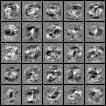

In [130]:
% Theta1: 25 x 401
% Weights related to hidden units a1 ... a25 in layer 2
% are displayed as pictures of maps with width 20 px = sqrt(400-1)
displayData(Theta1(:, 2:end));

## 8. Python Notes

In the following, some python implementations of selected functions are collected, taken from [ml-coursera-python-assignments](https://github.com/mxagar/ml-coursera-python-assignments). Note that the optimization function equivalent to `fmincg` is `scipy.optimize.minimize`; an example is provided in `ex2`.

```python
import numpy as np
from matplotlib import pyplot

def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        # Display Image
        h = ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                      cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')


def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network
    Outputs the predicted label of X given the trained weights of a neural
    network(Theta1, Theta2)
    """
    # Useful values
    m = X.shape[0]
    num_labels = Theta2.shape[0]

    # You need to return the following variables correctly
    p = np.zeros(m)
    h1 = sigmoid(np.dot(np.concatenate([np.ones((m, 1)), X], axis=1), Theta1.T))
    h2 = sigmoid(np.dot(np.concatenate([np.ones((m, 1)), h1], axis=1), Theta2.T))
    p = np.argmax(h2, axis=1)
    return p

def sigmoid(z):
    """
    Computes the sigmoid of z.
    """
    return 1.0 / (1.0 + np.exp(-z))

```